This notebook creates a Keras Sequence model and then trains it on the Kaggle Cars dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

In [1]:
# Setup
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [ ]:
## LOAD THE DATA ##
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    #'train',
    '/content/drive/MyDrive/tinyall',
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    #'valid',
    '/content/drive/MyDrive/tinyall',
    labels='inferred',
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# Define the model

model = keras.Sequential([
    layers.InputLayer(input_shape=[299, 299, 3]),
    
    # Data Augmentation
    # preprocessing.RandomContrast(factor=0.10),
    # preprocessing.RandomFlip(mode='horizontal'),
    # preprocessing.RandomRotation(factor=0.10),

    # Block One
    # layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()

## Train the Model
We can train this model by compiling it with an optimizer along with a loss and metric appropriate for binary classification.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=20,
    verbose=2,
)

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
# Save our trained model
model.save('/content/drive/MyDrive/TinyAllModel')


In [2]:
# reloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/TinyAllModel')b
reloaded_model = tf.keras.models.load_model('TinyAllModel')

In [ ]:
import visualkeras

model = reloaded_model

# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png', legend=True).show() # write and show

visualkeras.layered_view(model, legend=True)

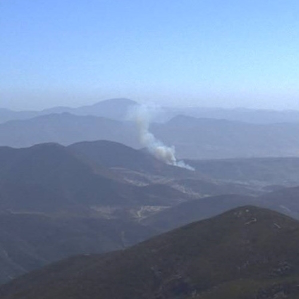

In [3]:
# specify the image to be displayed and classified
# image_path = '/content/drive/MyDrive/SmokeNoSmoke1.jpg'
image_path = 'SmokeNoSmoke12.jpg'
image_size = (299,299)
from PIL import Image
import cv2 
from IPython.display import display

img = cv2.imread(image_path) # with the OpenCV function imread(), the order of colors is BGR (blue, green, red).
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB for Pillow
display(Image.fromarray(img))


In [6]:
# 2 different ways to prepare the image and pass it for prediction.....here is the first
from tensorflow import keras
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = reloaded_model.predict(input_arr)

if predictions[0][0] == 0:
    print("The image contains no smoke.")

if predictions[0][0] == 1:
    print("The image contains smoke.")

print(predictions[0][0])
predictions.shape

The image contains no smoke.
0.0


(1, 1)

In [7]:
# 2 different ways to prepare the image and pass it for prediction.....here is the second
img = keras.preprocessing.image.load_img(
    image_path, target_size=image_size   
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = reloaded_model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent nosmoke and %.2f percent smoke."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent nosmoke and 0.00 percent nosmoke.


In [ ]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(reloaded_model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)